# Tech Challenge — Detecção de Tuberculose em Radiografias de Tórax

**Objetivo:** classificar RX de tórax para **triagem** em **Normal (0)** vs **Tuberculosis (1)**, priorizando **sensibilidade máxima** (sem falsos negativos).

**Classe positiva:** 1 = Tuberculosis  
**Política clínica:** **Recall = 1.00** (=> **FNR=0**) no **teste**.  
**Threshold:** escolhido **na validação** por varredura (FN=0 e **FP mínimo**) e **aplicado inalterado** ao teste.

**Dataset:** [Kaggle – TB Chest X-ray Database](https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset) (sem PHI; respeitar licença).

**Fluxo:** setup reprodutível → sanity/contagens → split 70/15/15 (estratificado) → `tf.data` + aug conservadora → Baseline (CNN) → Transfer Learning (MobileNetV2 + FT) → seleção de limiar na **validação** → métricas no **teste** → Grad-CAM++ → exportação.

**Relato no teste (com o limiar da validação):** Recall, **FNR**, **Specificity**, **NPV**, Precision, F1, AUC; **1** matriz de confusão; **ROC** e **PR**; **3–6** Grad-CAMs (incluindo FP).

> Uso acadêmico; não-diagnóstico. Resultados devem ser interpretados por profissionais de saúde.

## Configuração, Dependências e Reprodutibilidade

In [19]:
# Se utilizar google colab, descomente a linha abaixo para instalar as dependências 
# !pip install kagglehub tensorflow scikit-learn matplotlib opencv-python pillow tf-keras-vis

import os, random, shutil, sys, json, math, itertools, gc
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm as mpl_cm
import cv2
from PIL import Image
import kagglehub

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score)

from tf_keras_vis.gradcam import GradcamPlusPlus
from tf_keras_vis.utils import normalize
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

In [20]:
SEED = 13
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

## Dados e Sanity Check

In [21]:
path = kagglehub.dataset_download("tawsifurrahman/tuberculosis-tb-chest-xray-dataset")

DATA_DIR = Path(path) / "TB_Chest_Radiography_Database"
NORMAL_DIR = DATA_DIR / "Normal"
TB_DIR = DATA_DIR / "Tuberculosis"

valid_ext = {'.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'}

def count_images(d: Path):
    if not d.exists(): return 0
    return sum(1 for f in d.iterdir() if f.is_file() and f.suffix.lower() in valid_ext)

print("Normal:", count_images(NORMAL_DIR), "| TB:", count_images(TB_DIR))

# Sanity check: detectar arquivos corrompidos/“uniformes”
invalid = []
for img_path in DATA_DIR.rglob('*'):
    if img_path.suffix.lower() in valid_ext and img_path.is_file():
        try:
            im = Image.open(img_path); im.verify()
            im = Image.open(img_path).convert("RGB")
            arr = np.asarray(im)
            if arr.std() == 0:
                invalid.append((str(img_path), "imagem uniforme"))
        except Exception as e:
            invalid.append((str(img_path), f"erro: {e}"))

print("Suspeitas/Corrompidas:", len(invalid))
if invalid:
    with open("sanity_invalid.json","w") as f: json.dump(invalid, f, indent=2)
    print(f"Lista completa em sanity_invalid.json (n={len(invalid)})")

Normal: 3500 | TB: 700
Suspeitas/Corrompidas: 0
Suspeitas/Corrompidas: 0


## EDA e Split Estratificado 70/15/15

Total imagens: 4200
Distribuição: {'Normal': 3500, 'TB': 700}


,partição,Normal,TB,total
0,Treino,2450,490,2940
1,Validação,525,105,630
2,Teste,525,105,630


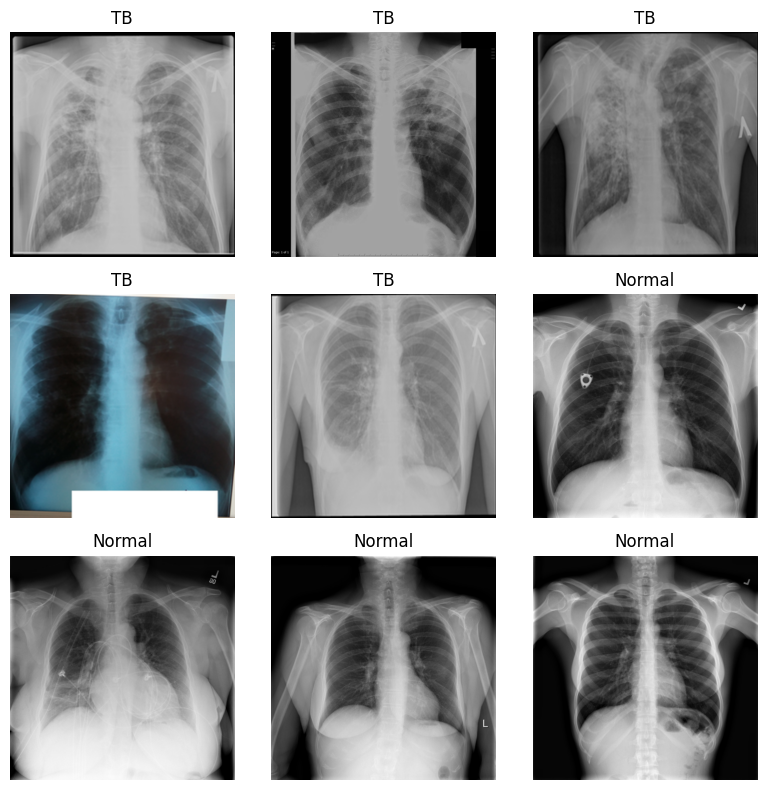

In [22]:
normal_paths = sorted([str(p) for p in (DATA_DIR / "Normal").glob("*") if p.suffix.lower() in valid_ext])
tb_paths     = sorted([str(p) for p in (DATA_DIR / "Tuberculosis").glob("*") if p.suffix.lower() in valid_ext])

X = normal_paths + tb_paths
y = [0]*len(normal_paths) + [1]*len(tb_paths)

print("Total imagens:", len(X))
print("Distribuição:", {"Normal": y.count(0), "TB": y.count(1)})

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=SEED)

def counts(lbls):
    a = np.array(lbls)
    return {0: int((a == 0).sum()), 1: int((a == 1).sum())}

df_split = pd.DataFrame({
    "partição": ["Treino","Validação","Teste"],
    "Normal": [counts(y_train)[0], counts(y_val)[0], counts(y_test)[0]],
    "TB": [counts(y_train)[1], counts(y_val)[1], counts(y_test)[1]],
    "total":  [len(y_train), len(y_val), len(y_test)]
})
display(df_split)

# copie todas as imagens do conjunto X_test para a pasta ./dataset/test_images/ contendo subpastas 'Normal' e 'Tuberculosis' conforme os rótulos y_test
TEST_DIR = Path("./dataset/test_images")
NORMAL_TEST_DIR = TEST_DIR / "Normal"
TB_TEST_DIR = TEST_DIR / "Tuberculosis"
NORMAL_TEST_DIR.mkdir(parents=True, exist_ok=True)
TB_TEST_DIR.mkdir(parents=True, exist_ok=True)
for i, p in enumerate(X_test):
    img = keras.utils.load_img(p)
    label = "TB" if y_test[i] == 1 else "Normal"
    if label == "Normal":
        img.save(NORMAL_TEST_DIR / f"{Path(p).name}")
    else:
        img.save(TB_TEST_DIR / f"{Path(p).name}")


# Visualização de algumas amostras
plt.figure(figsize=(8,8))
# We want exactly 5 TB and 4 Normal images from the training set
tb_count = 0
normal_count = 0
plot_idx = 0
# iterate over X_train together with y_train (use the split labels)
for p, label in zip(X_train, y_train):
    if plot_idx >= 9:
        break
    # select TB images first (5), then Normal images (4)
    select = False
    if (tb_count < 5 and label == 1) or (tb_count >= 5 and normal_count < 4 and label == 0):
        select = True
    if not select:
        continue
    # update counters and plot
    if label == 1:
        tb_count += 1
    else:
        normal_count += 1
    img = keras.utils.load_img(p)
    plt.subplot(3,3,plot_idx+1)
    plt.imshow(img); plt.axis('off')
    plt.title("TB" if label==1 else "Normal")
    plot_idx += 1
plt.tight_layout(); plt.show()



## Pipeline de Dados (tf.data) & Class Weights

In [23]:
IMG_SIZE = (224,224)
BATCH = 32
AUTO = tf.data.AUTOTUNE

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def aug(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.1)
    return img, label

def make_ds(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_image, num_parallel_calls=AUTO)
    if training:
        ds = ds.shuffle(2048, seed=SEED).map(aug, num_parallel_calls=AUTO)
    return ds.batch(BATCH).prefetch(AUTO)

train_ds = make_ds(np.array(X_train), np.array(y_train), training=True)
val_ds   = make_ds(np.array(X_val), np.array(y_val))
test_ds  = make_ds(np.array(X_test), np.array(y_test))

class_weights_arr = compute_class_weight('balanced', classes=np.array([0,1]), y=np.array(y_train))
CLASS_WEIGHTS = {0: float(class_weights_arr[0]), 1: float(class_weights_arr[1])}
print("Class Weights:", CLASS_WEIGHTS)


Class Weights: {0: 0.6, 1: 3.0}


## Modelos

Modelo 1 - CNN Baseline

In [ ]:
def build_baseline():
    inputs = layers.Input(shape=IMG_SIZE+(3,))
    x = layers.Conv2D(32, 3, activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    m = keras.Model(inputs, outputs)
    m.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.Precision(name='prec'), keras.metrics.Recall(name='rec')])
    return m

baseline = build_baseline()
callbacks = [
    EarlyStopping(monitor='val_rec', mode='max', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_rec', mode='max', factor=0.2, patience=2),
    ModelCheckpoint('cnn.keras', monitor='val_rec', mode='max', save_best_only=True)
]
hist_base = baseline.fit(train_ds, validation_data=val_ds,
                         epochs=20, class_weight=CLASS_WEIGHTS,
                         callbacks=callbacks, verbose=0)

model_path = Path(__file__).parent / "api" / "model" / "cnn.keras"
baseline.save(str(model_path))


Modelo 2 - Transfer Learning (MobileNetV2)

In [ ]:
def build_transfer():
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE+(3,))
    base.trainable = False
    inputs = Input(shape=IMG_SIZE+(3,))
    x = layers.Rescaling(scale=2.0, offset=-1.0)(inputs)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    m = Model(inputs, outputs)
    m.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.Precision(name='prec'), keras.metrics.Recall(name='rec')])
    return m, base

transfer, backbone = build_transfer()

callbacks_tl = [
    EarlyStopping(monitor='val_rec', mode='max', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_rec', mode='max', factor=0.2, patience=2),
    ModelCheckpoint('mobileNetV2.keras', monitor='val_rec', mode='max', save_best_only=True)
]

hist_tl = transfer.fit(train_ds, validation_data=val_ds, epochs=15,
                       class_weight=CLASS_WEIGHTS, callbacks=callbacks_tl)

# Fine-tuning leve
for layer in backbone.layers[-40:]:
    layer.trainable = True

transfer.compile(optimizer=keras.optimizers.Adam(1e-4), loss='binary_crossentropy',
                 metrics=['accuracy', keras.metrics.Precision(name='prec'), keras.metrics.Recall(name='rec')])

hist_tl_ft = transfer.fit(train_ds, validation_data=val_ds, epochs=10,
                          class_weight=CLASS_WEIGHTS, callbacks=callbacks_tl)

model_path = Path(__file__).parent / "api" / "model" / "mobileNetV2.keras"
transfer.save(str(model_path))

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.8178 - loss: 0.4477 - prec: 0.4706 - rec: 0.7376

92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 222ms/step - accuracy: 0.8874 - loss: 0.3219 - prec: 0.6192 - rec: 0.8429 - val_accuracy: 0.9841 - val_loss: 0.1245 - val_prec: 0.9204 - val_rec: 0.9905
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 213ms/step - accuracy: 0.9724 - loss: 0.1203 - prec: 0.8822 - rec: 0.9633 - val_accuracy: 0.9968 - val_loss: 0.0494 - val_prec: 0.9905 - val_rec: 0.9905
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 216ms/step - accuracy: 0.9833 - loss: 0.0891 - prec: 0.9332 - rec: 0.9694 - val_accuracy: 0.9952 - val_loss: 0.0456 - val_prec: 0.9811 - val_rec: 0.9905
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9870 - loss: 0.0634 - prec: 0.9331 - rec: 0.9933

92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 213ms/step - accuracy: 0.9850 - loss: 0.0669 - prec: 0.9322 - rec: 0.9816 - val_accuracy: 0.9968 - val_loss: 0.0353 - val_prec: 0.9813 - val_rec: 1.0000
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.9874 - loss: 0.0593 - prec: 0.9415 - rec: 0.9857 - val_accuracy: 0.9968 - val_loss: 0.0262 - val_prec: 0.9905 - val_rec: 0.9905
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - accuracy: 0.9908 - loss: 0.0499 - prec: 0.9658 - rec: 0.9796 - val_accuracy: 0.9968 - val_loss: 0.0297 - val_prec: 0.9813 - val_rec: 1.0000
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 233ms/step - accuracy: 0.9884 - loss: 0.0404 - prec: 0.9471 - rec: 0.9857 - val_accuracy: 0.9984 - val_loss: 0.0192 - val_prec: 0.9906 - val_rec: 1.0000
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 268ms/step - accuracy: 0.9908 - loss: 0.0393 - prec: 0.9602 - rec: 0.9857 - val_accuracy: 0.9968 - val_loss: 0.0238 - val_prec: 0.9813 - val_rec: 1.0000
Epoch 9/15
92/92 ━━━━━━━━━━━━━━━━━━━

## Avaliação Clínica — Threshold, Curvas e Métricas (Teste)

### Seleção de Limiar na Validação (FN = 0)

Threshold (VAL) escolhido: 0.36 (FN=0; FP mínimo na validação)


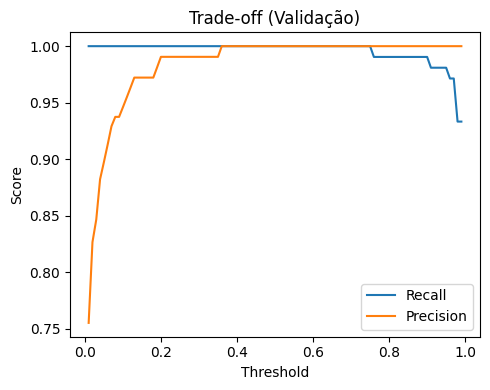

In [58]:
y_prob_val = transfer.predict(val_ds, verbose=0).ravel()
y_true_val = np.array(y_val)

thr_grid = np.linspace(0.01, 0.99, 99)
records = []
for thr in thr_grid:
    y_pred = (y_prob_val >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true_val, y_pred).ravel()
    rec  = recall_score(y_true_val, y_pred, zero_division=0)
    prec = precision_score(y_true_val, y_pred, zero_division=0)
    f1   = f1_score(y_true_val, y_pred, zero_division=0)
    records.append((thr, prec, rec, f1, tn, fp, fn, tp))

df_thr = pd.DataFrame(records, columns=["thr","prec","rec","f1","tn","fp","fn","tp"])

# Escolha clínica: impor FN=0 e, entre esses, minimizar FP (tie-break por menor thr)
df_zeroFN = df_thr[df_thr["fn"] == 0]
assert len(df_zeroFN) > 0, "Nenhum threshold zera FN na validação (ajuste modelo/policy)."
best_thr_zeroFN = float(df_zeroFN.sort_values(["fp","thr"]).iloc[0]["thr"])
print(f"Threshold (VAL) escolhido: {best_thr_zeroFN:.2f} (FN=0; FP mínimo na validação)")

# Plot do trade-off (validação)
plt.figure(figsize=(5,4))
plt.plot(df_thr["thr"], df_thr["rec"], label="Recall")
plt.plot(df_thr["thr"], df_thr["prec"], label="Precision")
plt.xlabel("Threshold"); plt.ylabel("Score"); plt.title("Trade-off (Validação)")
plt.legend(); plt.tight_layout()
plt.show()

In [65]:
def report(y_true, y_prob, thr, title):
    y_pred = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    auc  = roc_auc_score(y_true, y_prob)
    spec = tn / (tn + fp + 1e-12)
    fnr  = fn / (fn + tp + 1e-12)
    npv  = tn / (tn + fn + 1e-12)
    print(f"[{title}] thr={thr:.2f} -> TN={tn} FP={fp} FN={fn} TP={tp}")
    print(f"ACC={acc:.4f} | PREC={prec:.4f} | REC={rec:.4f} | SPEC={spec:.4f} | FNR={fnr:.4f} | NPV={npv:.4f} | F1={f1:.4f} | AUC={auc:.4f}")

y_true_test = np.array(y_test)
y_prob_test = transfer.predict(test_ds, verbose=0).ravel()

# Validação (confirma FN=0 por construção)
report(np.array(y_val), y_prob_val, best_thr_zeroFN, "VALIDAÇÃO (FN=0)")

# Teste (mesmo limiar da validação)
report(y_true_test, y_prob_test, best_thr_zeroFN, "TESTE (mesmo limiar)")

[VALIDAÇÃO (FN=0)] thr=0.36 -> TN=525 FP=0 FN=0 TP=105
ACC=1.0000 | PREC=1.0000 | REC=1.0000 | SPEC=1.0000 | FNR=0.0000 | NPV=1.0000 | F1=1.0000 | AUC=1.0000
[TESTE (mesmo limiar)] thr=0.36 -> TN=517 FP=8 FN=0 TP=105
ACC=0.9873 | PREC=0.9292 | REC=1.0000 | SPEC=0.9848 | FNR=0.0000 | NPV=1.0000 | F1=0.9633 | AUC=0.9998


### Curvas ROC & Precision–Recall

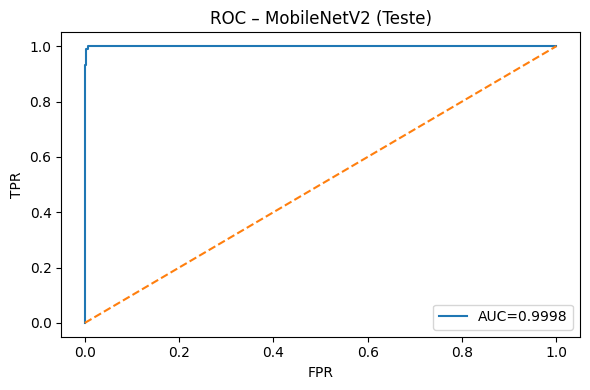

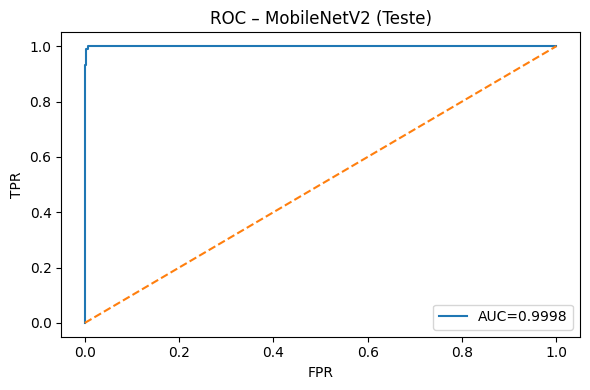

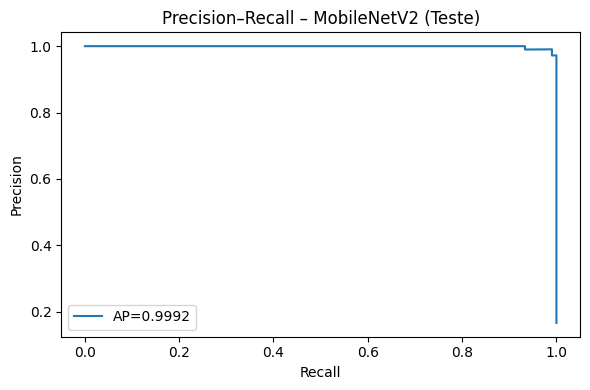

In [ ]:
y_true = np.array(y_test)

def plot_curves(y_true, y_prob, title, save_prefix=None):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    ap  = average_precision_score(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)

    # ROC
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC – {title}")
    plt.legend(loc="lower right")
    if save_prefix:
        plt.savefig(f"{save_prefix}_roc.png", dpi=150, bbox_inches="tight")
    plt.tight_layout(); plt.show()

    # PR
    plt.figure(figsize=(6,4))
    plt.plot(rec, prec, label=f"AP={ap:.4f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"Precision–Recall – {title}")
    plt.legend(loc="lower left")
    if save_prefix:
        plt.savefig(f"{save_prefix}_pr.png", dpi=150, bbox_inches="tight")
    plt.tight_layout(); plt.show()

plot_curves(y_true, y_prob_test, title="MobileNetV2 (Teste)", save_prefix="mobilenetv2")

Avaliação no Teste (Limiar da Validação)

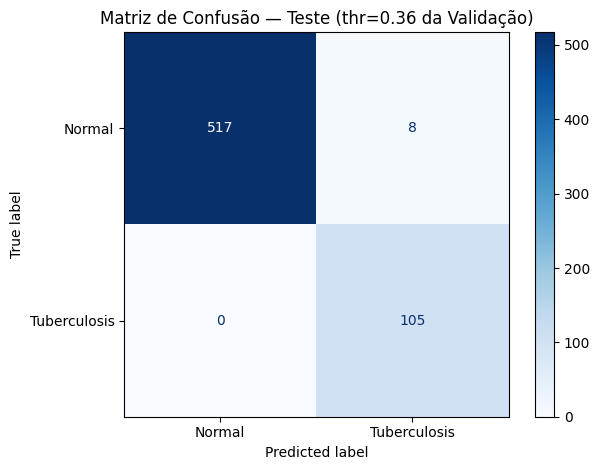

,modelo,tipo,thr,acc,prec,rec,spec,fnr,npv,f1,auc,tn,fp,fn,tp
0,MobileNetV2,default(0.50),0.5000,0.9952,0.9722,1.0000,0.9943,0.0000,1.0000,0.9859,0.9998,522,3,0,105
1,MobileNetV2,val_zeroFN,0.3600,0.9873,0.9292,1.0000,0.9848,0.0000,1.0000,0.9633,0.9998,517,8,0,105


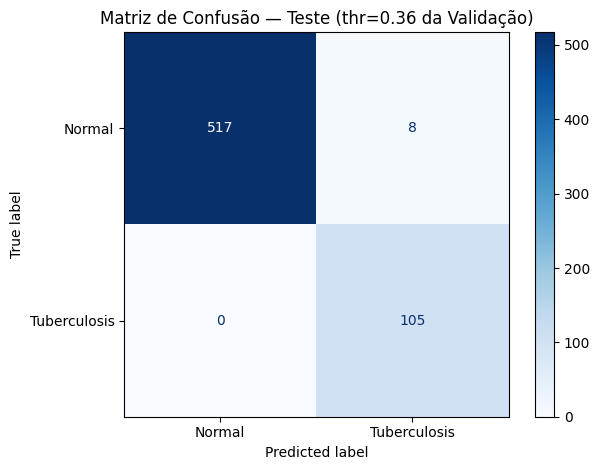

,modelo,tipo,thr,acc,prec,rec,spec,fnr,npv,f1,auc,tn,fp,fn,tp
0,MobileNetV2,default(0.50),0.5000,0.9952,0.9722,1.0000,0.9943,0.0000,1.0000,0.9859,0.9998,522,3,0,105
1,MobileNetV2,val_zeroFN,0.3600,0.9873,0.9292,1.0000,0.9848,0.0000,1.0000,0.9633,0.9998,517,8,0,105


Limiar da validação (thr=0.36) manteve FN=0 no TESTE (Recall=1.00).


In [61]:
def _metrics_from_probs(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    auc  = roc_auc_score(y_true, y_prob)
    spec = tn / (tn + fp + 1e-12)
    fnr  = fn / (fn + tp + 1e-12)
    npv  = tn / (tn + fn + 1e-12)
    return {
        "thr": float(thr), "acc": float(acc), "prec": float(prec), "rec": float(rec),
        "spec": float(spec), "fnr": float(fnr), "npv": float(npv),
        "f1": float(f1), "auc": float(auc),
        "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)
    }

m_val = _metrics_from_probs(y_true_test, y_prob_test, best_thr_zeroFN)
cm = np.array([[m_val["tn"], m_val["fp"]],
               [m_val["fn"], m_val["tp"]]], dtype=int)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal','Tuberculosis']).plot(cmap='Blues')
plt.title(f"Matriz de Confusão — Teste (thr={best_thr_zeroFN:.2f} da Validação)")
plt.tight_layout(); plt.show()

rows = []
rows.append({"modelo": "MobileNetV2", "tipo": "default(0.50)",
             **_metrics_from_probs(y_true_test, y_prob_test, 0.50)})
rows.append({"modelo": "MobileNetV2", "tipo": "val_zeroFN",
             **m_val})

df_eval = pd.DataFrame(rows)
cols = ["modelo","tipo","thr","acc","prec","rec","spec","fnr","npv","f1","auc","tn","fp","fn","tp"]
df_eval = df_eval[cols]

with pd.option_context('display.float_format', lambda x: f"{x:.4f}"):
    display(df_eval)

if m_val["fn"] == 0:
    print(f"Limiar da validação (thr={best_thr_zeroFN:.2f}) manteve FN=0 no TESTE (Recall=1.00).")
else:
    print(f"Com thr={best_thr_zeroFN:.2f} houve FN>0 no TESTE — reavaliar política/treino.")

## Interpretabilidade (Grad-CAM++)

### Grad-CAM++ para o CNN (modelo 1)

Última Conv2D (Baseline): conv2d_11


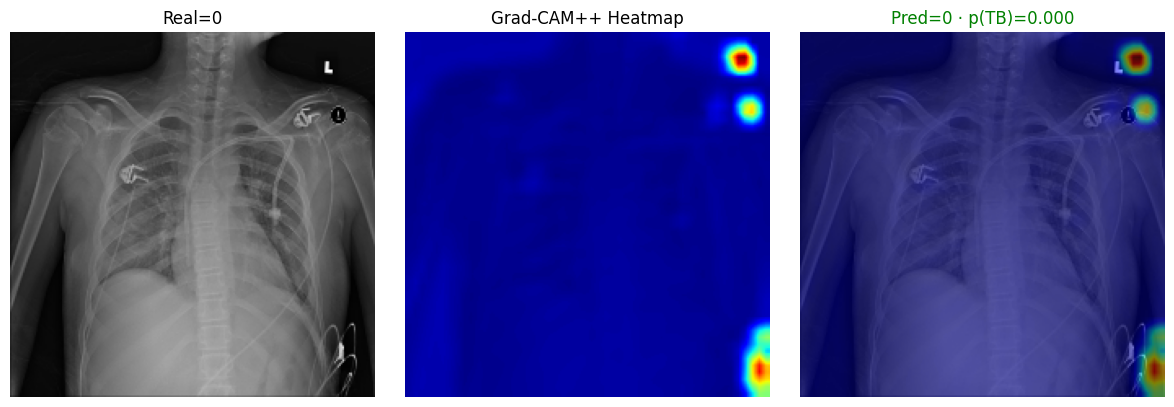

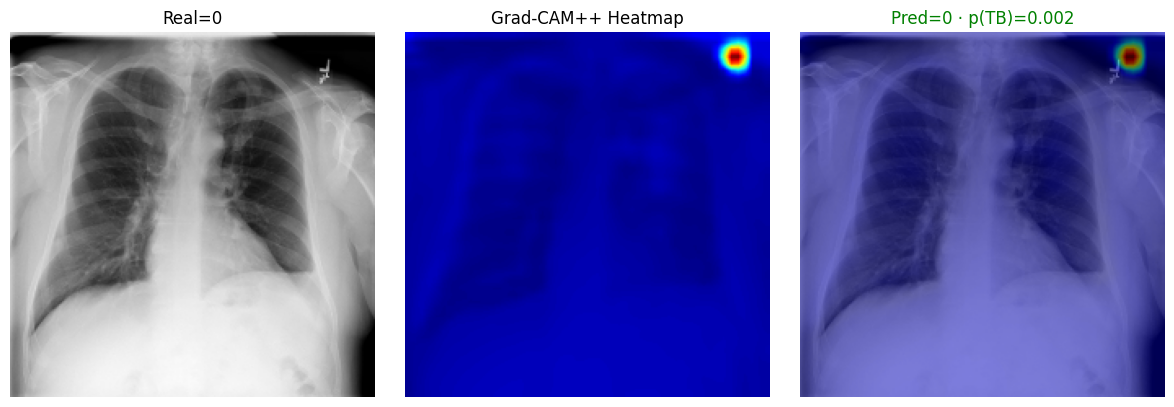

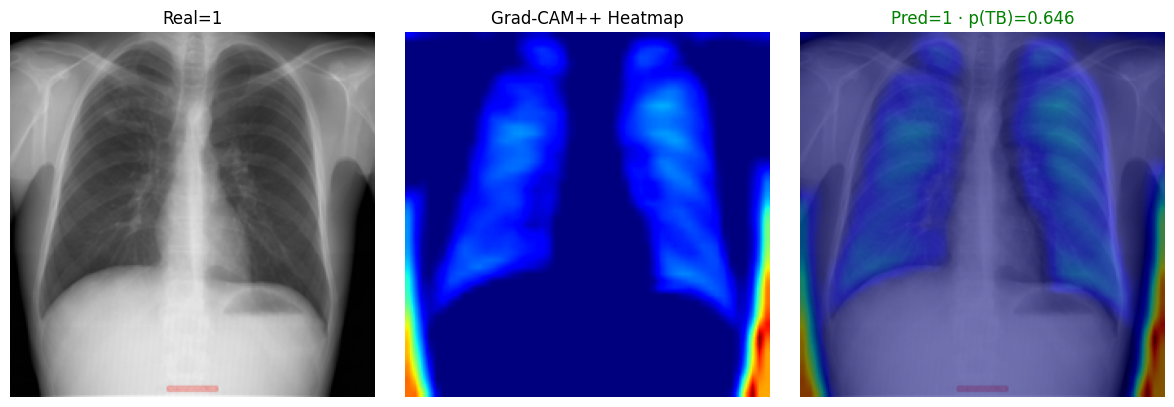

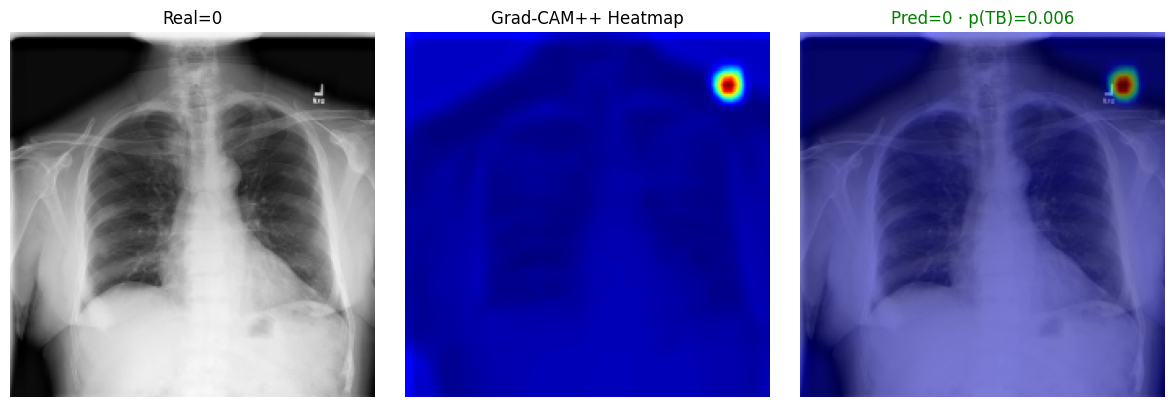

Probabilidades (TB): min=0.000, max=0.977, média=0.282


In [63]:
def make_gradcam_plusplus_baseline(model, img_array, last_conv_layer_name):
    """
    Implementação customizada de Grad-CAM++ para modelo Sequential (Baseline).
    """
    
    conv_layer_index = None
    for i, layer in enumerate(model.layers):
        if layer.name == last_conv_layer_name:
            conv_layer_index = i
            break

    if conv_layer_index is None:
        raise ValueError(f"Camada {last_conv_layer_name} não encontrada")

    with tf.GradientTape() as tape:
        x = tf.constant(img_array)

        # Iterar pelas camadas até a camada convolucional desejada
        for i in range(conv_layer_index + 1):
            layer = model.layers[i]
            # Pular a camada Input ou aplicar corretamente
            if isinstance(layer, tf.keras.layers.InputLayer):
                continue
            x = layer(x, training=False)

        conv_outputs = x
        tape.watch(conv_outputs)

        # Aplicar as camadas restantes
        for i in range(conv_layer_index + 1, len(model.layers)):
            layer = model.layers[i]
            if isinstance(layer, tf.keras.layers.InputLayer):
                continue
            x = layer(x, training=False)

        predictions = x
        class_channel = predictions[:, 0]

    grads = tape.gradient(class_channel, conv_outputs)

    first_derivative = tf.exp(class_channel)[..., None, None, None] * grads
    second_derivative = first_derivative * grads
    third_derivative = second_derivative * grads

    global_sum = tf.reduce_sum(conv_outputs, axis=(1, 2), keepdims=True)

    alpha_denom = (second_derivative * 2.0) + (third_derivative * global_sum) + 1e-10
    alpha_num = second_derivative
    alpha = alpha_num / alpha_denom

    alpha_normalization_constant = tf.reduce_sum(alpha, axis=(1, 2), keepdims=True)
    alpha /= (alpha_normalization_constant + 1e-10)

    weights = tf.maximum(first_derivative, 0.0)
    weights = tf.reduce_sum(alpha * weights, axis=(1, 2))

    cam = tf.reduce_sum(tf.multiply(weights[:, None, None, :], conv_outputs), axis=-1)
    cam = tf.maximum(cam, 0)

    return cam.numpy()

last_conv_baseline = None
for layer in reversed(baseline.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_baseline = layer.name
        break

if last_conv_baseline is None:
    raise RuntimeError("Não encontrei camada Conv2D no baseline para Grad-CAM++.")

print("Última Conv2D (Baseline):", last_conv_baseline)

test_batch_imgs_b, test_batch_lbls_b = next(iter(test_ds))
test_batch_imgs_b = test_batch_imgs_b.numpy()
test_batch_lbls_b = test_batch_lbls_b.numpy().astype(int)

all_probs_base = baseline.predict(test_batch_imgs_b, verbose=0).ravel()

cam_base = make_gradcam_plusplus_baseline(baseline, test_batch_imgs_b, last_conv_baseline)

cam_normalized = np.zeros_like(cam_base)
for i in range(len(cam_base)):
    cam_normalized[i] = (cam_base[i] - cam_base[i].min()) / (cam_base[i].max() - cam_base[i].min() + 1e-8)

N = min(4, len(test_batch_imgs_b))
for i in range(N):
    img = (test_batch_imgs_b[i] * 255).astype(np.uint8)

    heat = cv2.resize(cam_normalized[i], img.shape[:2][::-1])
    heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-8)

    heatmap = np.uint8(mpl_cm.jet(heat)[..., :3] * 255)
    overlay = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

    p = float(all_probs_base[i])
    pred = int(p >= best_thr_zeroFN)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img)
    axs[1].imshow(heatmap)
    axs[2].imshow(overlay)

    axs[0].set_title(f"Real={test_batch_lbls_b[i]}")
    axs[1].set_title("Grad-CAM++ Heatmap")
    axs[2].set_title(f"Pred={pred} · p(TB)={p:.3f}",
                     color="green" if pred == test_batch_lbls_b[i] else "red")

    for ax in axs:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

print(f"Probabilidades (TB): min={all_probs_base.min():.3f}, max={all_probs_base.max():.3f}, média={all_probs_base.mean():.3f}")

### Grad-CAM++ para Transfer Learning (MobileNetV2) (modelo 2)

Última Conv: Conv_1


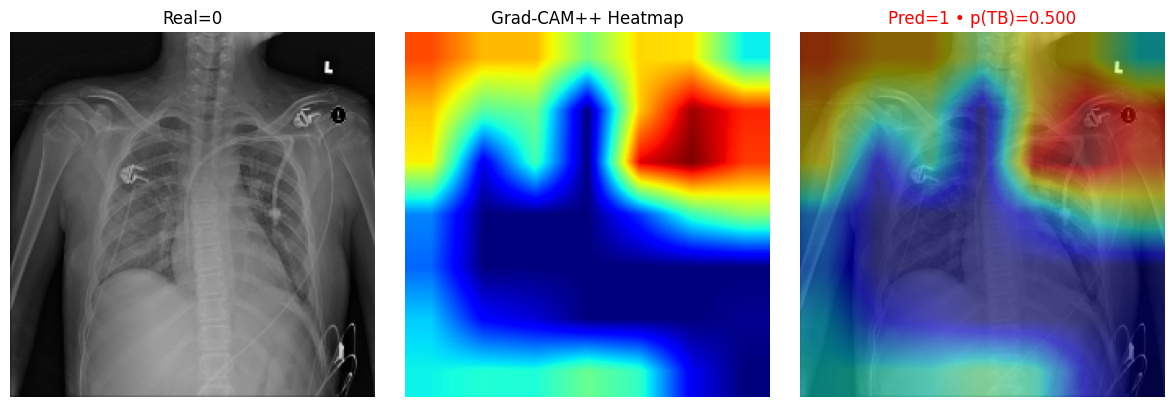

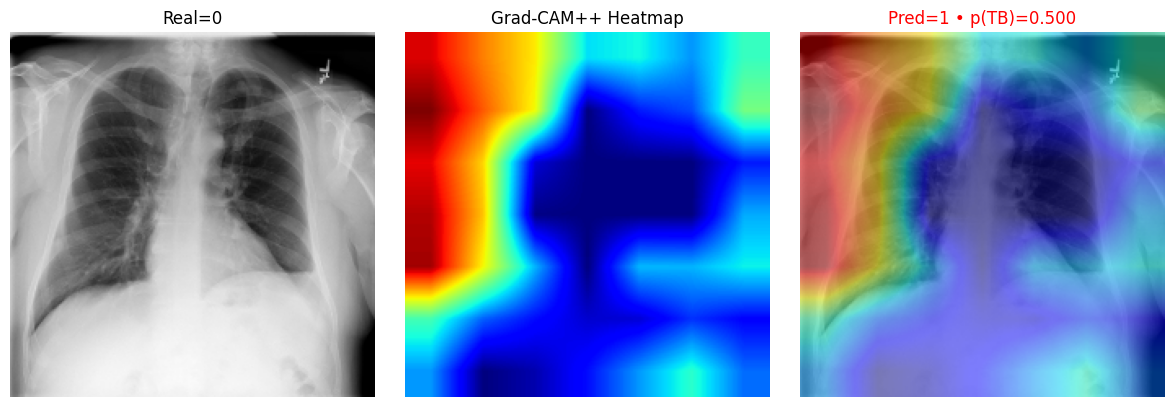

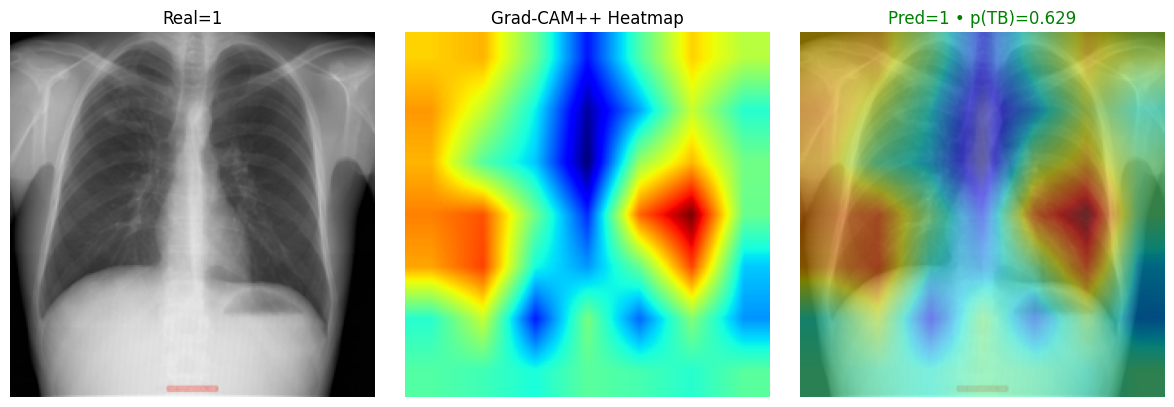

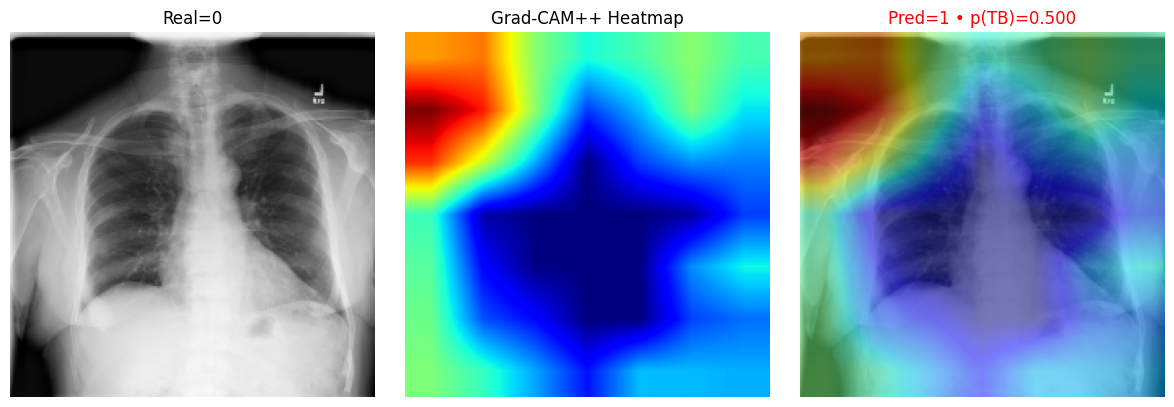

Probabilidades (TB): min=0.500, max=0.731, média=0.533


In [64]:
def make_gradcam_plusplus_heatmap(model, backbone, img_array, last_conv_layer_name, pred_index=None):
    """
    Implementação customizada de Grad-CAM++ para melhor compatibilidade.
    Usa o backbone para acessar camadas internas do MobileNetV2.
    """
    conv_layer = backbone.get_layer(last_conv_layer_name)

    feature_extractor = tf.keras.models.Model(
        inputs=backbone.input,
        outputs=conv_layer.output
    )

    with tf.GradientTape() as tape:
        conv_outputs = feature_extractor(img_array, training=False)
        tape.watch(conv_outputs)

        x = conv_outputs
        for layer in backbone.layers[backbone.layers.index(conv_layer) + 1:]:
            x = layer(x, training=False)

        gap_layer = [l for l in model.layers if 'global_average_pooling2d' in l.name][0]
        dropout_layer = [l for l in model.layers if 'dropout' in l.name][-1]
        dense_layer = [l for l in model.layers if 'dense' in l.name][-1]

        x = gap_layer(x)
        x = dropout_layer(x, training=False)
        predictions = dense_layer(x)

        if pred_index is None:
            pred_index = 0
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    first_derivative = tf.exp(class_channel)[..., None, None, None] * grads
    second_derivative = first_derivative * grads
    third_derivative = second_derivative * grads

    global_sum = tf.reduce_sum(conv_outputs, axis=(1, 2), keepdims=True)

    alpha_denom = (second_derivative * 2.0) + (third_derivative * global_sum) + 1e-10
    alpha_num = second_derivative
    alpha = alpha_num / alpha_denom

    alpha_normalization_constant = tf.reduce_sum(alpha, axis=(1, 2), keepdims=True)
    alpha /= (alpha_normalization_constant + 1e-10)

    weights = tf.maximum(first_derivative, 0.0)
    weights = tf.reduce_sum(alpha * weights, axis=(1, 2))

    cam = tf.reduce_sum(tf.multiply(weights[:, None, None, :], conv_outputs), axis=-1)
    cam = tf.maximum(cam, 0)

    return cam.numpy()

test_batch_imgs, test_batch_lbls = next(iter(test_ds))
test_batch_imgs = test_batch_imgs.numpy()
test_batch_lbls = test_batch_lbls.numpy().astype(int)

last_conv = None
for layer in backbone.layers[::-1]:
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv = layer.name
        break

if last_conv is None:
    last_conv = 'Conv_1'

print("Última Conv:", last_conv)
all_probs = tf.nn.sigmoid(transfer.predict(test_batch_imgs, verbose=0)).numpy().ravel()

cam = make_gradcam_plusplus_heatmap(transfer, backbone, test_batch_imgs, last_conv)

cam_normalized = np.zeros_like(cam)
for i in range(len(cam)):
    cam_normalized[i] = (cam[i] - cam[i].min()) / (cam[i].max() - cam[i].min() + 1e-8)

for i in range(min(4, len(test_batch_imgs))):
    img = (test_batch_imgs[i] * 255).astype(np.uint8)

    heat = cv2.resize(cam_normalized[i], img.shape[:2][::-1])
    heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-8)

    heatmap = np.uint8(mpl_cm.jet(heat)[..., :3] * 255)
    overlay = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

    p = float(all_probs[i])
    pred = int(p >= best_thr_zeroFN)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img)
    axs[1].imshow(heatmap)
    axs[2].imshow(overlay)

    axs[0].set_title(f"Real={test_batch_lbls[i]}")
    axs[1].set_title("Grad-CAM++ Heatmap")
    axs[2].set_title(f"Pred={pred} • p(TB)={p:.3f}",
                     color="green" if pred == test_batch_lbls[i] else "red")

    for ax in axs:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

print(f"Probabilidades (TB): min={all_probs.min():.3f}, max={all_probs.max():.3f}, média={all_probs.mean():.3f}")


## Conclusões & Limitações

Com o limiar definido na validação (0,36, regra “FN=0 e FP mínimo”), o modelo MobileNetV2 com fine-tuning entregou, no conjunto de teste: Recall = 1,00 (FN = 0), Precision = 0,9292, Specificity = 0,9848, F1 = 0,9633, AUC-ROC ≈ 0,9998 e NPV = 1,00.
Esses números são compatíveis com o objetivo de triagem (prioridade absoluta para sensibilidade), mantendo a taxa de falsos positivos em um nível baixo para o cenário.

As curvas ROC e Precision–Recall reforçam a separação entre as classes (AUC/AP ~1). A matriz de confusão no teste confirma a política clínica: não houve perda de casos de TB. Vale registrar que a tabela comparativa mostrou que thr = 0,50 também manteve FN = 0 no teste e reduziu FP (3 vs 8); portanto, existe espaço para operar com um limiar um pouco mais conservador sem abrir mão do recall, desde que essa escolha seja corroborada fora do conjunto de teste.

Nos exemplos de Grad-CAM++, a ativação se concentra, em geral, nas regiões pulmonares, como esperado. Em alguns casos, aparecem focos periféricos (bordas/artefatos), o que acende um alerta para potenciais “atalhos visuais” não clínicos, especialmente nos poucos FP.

Em resumo: dentro do escopo acadêmico, o sistema cumpre o que se propôs — triagem com FNR = 0 — e apresenta desempenho global robusto, coerente com a tarefa e com a política de segurança adotada.

### Limitações

Divisão por imagem (e não por paciente): o dataset do Kaggle não garante separação por paciente, o que pode inflar métricas.

Generalização externa: foi utilizada uma única base, em PNG, sem validação em outros domínios (instituições, protocolos, DICOM).

Artefatos visuais: alguns mapas de calor indicam atenção a bordas/marcadores; há risco de o modelo aprender pistas fora da anatomia.

Calibração de probabilidade: não foi avaliada; para triagem, probabilidades calibradas ajudam na priorização.

Escolha do limiar: embora feita corretamente na validação e aplicada ao teste, o “ponto operacional” mostrou variação possível entre 0,36 e 0,50; seria saudável confirmar essa estabilidade com mais dados.